# Clickstream Analysis 

## Importing Libraries

In [15]:
! pip install pandas-profiling

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
! pip install python-Levenshtein

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import pandas as pd                                                   #Used for data manipulation and analysis.
import numpy as np                                                    #Used for mathematical and statistical operations on arrays of data.
import seaborn as sns                                                 #Built on top of Matplotlib, seaborn is used for data visualization.
import matplotlib.pyplot as plt                                       #For creating interactive visualizations in Python.
import ipywidgets as widgets
from pandas_profiling import ProfileReport

In [18]:
from IPython.display import HTML                                      #Allows to display HTML content in Jupyter Notebooks.
import time                                                           #Provides time-related functions and utilities
from datetime import datetime                                         #Used for working with dates and times.
from sklearn.preprocessing import LabelEncoder, StandardScaler        #used for encoding categorical variables into numerical values./used for feature scaling (standardization)
from sklearn.model_selection import train_test_split

In [19]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.models import Model                             #employed for building and training deep learning models
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout   #A fully connected layer, often used for classification or regression tasks.
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from tensorflow import keras
from sklearn.metrics import classification_report
from keras.preprocessing.sequence import pad_sequences

##### TensorFlow allows to create dataflow graphs that describe how data moves through a graph.The graph consists of nodes that represent a mathematical operation. ####

## Importing Dataset

In [20]:
num_rows = 10000
original_df = pd.read_csv("C:\\Users\\SAPTARSHI BHATTACHAR\\Desktop\\access.csv", nrows=num_rows)
original_df = original_df.sample(frac=1, random_state=42)
original_df.head(2)

,client,userid,datetime,method,request,status,size,referer,user_agent
6252,31.59.209.196,-,22/Jan/2019:12:40:35 +0330,GET,/image/34206?name=om7560-77.jpg&wh=max,200,39337,https://www.zanbil.ir/m/product/34206/65185/%D...,Mozilla/5.0 (Linux; Android 7.0; SAMSUNG SM-N9...
4684,109.162.200.153,-,22/Jan/2019:12:40:01 +0330,GET,/image/5/productType/240x180,200,11487,https://www.zanbil.ir/m/browse/big-kitchen-app...,Mozilla/5.0 (Linux; U; Android 4.2.2; fa-ir; H...


In [21]:
original_df = original_df.drop(columns=['userid'])

In [22]:
original_df = original_df[~original_df['request'].str.contains('\.css|\.js')]

In [23]:
# Drop rows where either 'request' or 'referer' column has the value '/'
original_df = original_df[(original_df['request'] != '/')] #& (original_df['referer'] != '/')]
# Drop rows where either 'request' or 'referer' column has the value '/'
original_df = original_df[(original_df['request'] != '-')] #& (original_df['referer'] != '-')]

In [24]:
original_df["datetime"] = pd.to_datetime(original_df["datetime"], format="%d/%b/%Y:%H:%M:%S %z", errors='coerce')

In [25]:
original_df["datetime"] = original_df["datetime"].dt.strftime("%d/%b/%Y:%H:%M:%S")

In [26]:
original_df = original_df.dropna(subset=["referer"])
original_df = original_df.dropna(subset=["user_agent"])            #dropping rows which have null values

In [27]:
original_df["datetime"] = pd.to_datetime(original_df["datetime"], format="%d/%b/%Y:%H:%M:%S")
# Sort the DataFrame by client(IP address) and datetime
original_df = original_df.sort_values(by=["client", "datetime"])
original_df.head(2)

,client,datetime,method,request,status,size,referer,user_agent
262,10.65.253.5,2019-01-22 12:38:33,GET,/static/images/favicon.ico,200,152,-,Mozilla/5.0 (Windows NT 6.3; Win64; x64; Tride...
6238,104.194.24.237,2019-01-22 12:40:34,POST,/order/onlinePayment,200,33390,https://www.zanbil.ir/order/completionAndRemai...,Mozilla/5.0 (Windows NT 10.0; rv:64.0) Gecko/2...


In [28]:
original_df.shape

(9617, 8)

## Breaking Sessions ##

In [29]:
link_html = """<a href="https://learn.microsoft.com/en-us/previous-versions/iis/6.0-sdk/ms525473(v=vs.90)">Link to Microsoft Session Timeout.</a>"""
display(HTML(link_html))

**It is recommended to set the session timeout to 10 minutes. This is a standard default setting that works well for most websites. That's why I chose the threshold to be 10 minutes.**

In [30]:
# Calculate the time difference for each row within the same client group
original_df['time_diff'] = original_df.groupby("client")['datetime'].diff().fillna(pd.Timedelta(0))

# Create a boolean mask for when the time difference is greater than 600 seconds
mask = original_df['time_diff'].dt.total_seconds() > 600

# Calculate the session count for each client based on the mask and cumulative sum
original_df['session'] = mask.groupby(original_df['client']).cumsum() + 1

## Creating clicks for every user_id session wise ##

In [31]:
original_df = original_df.sort_values(by=['client','session'])

# Group by 'user_id' and 'session', then get the cumulative count
original_df['clicks'] = original_df.groupby(['client', 'session']).cumcount() + 1

**=====================================**

## Creating page_id variable ##

In [32]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder on the data and transform the variable
original_df['page_id'] = label_encoder.fit_transform(original_df['request'])
original_df['page_id']=original_df['page_id'].astype('category')
# To inverse transform back to original labels
#decoded_data = label_encoder.inverse_transform(encoded_data)
original_df.head(2)

,client,datetime,method,request,status,size,referer,user_agent,time_diff,session,clicks,page_id
262,10.65.253.5,2019-01-22 12:38:33,GET,/static/images/favicon.ico,200,152,-,Mozilla/5.0 (Windows NT 6.3; Win64; x64; Tride...,0 days,1,1,4623
6238,104.194.24.237,2019-01-22 12:40:34,POST,/order/onlinePayment,200,33390,https://www.zanbil.ir/order/completionAndRemai...,Mozilla/5.0 (Windows NT 10.0; rv:64.0) Gecko/2...,0 days,1,1,4142


In [33]:
unique_encoded_values = original_df['page_id'].nunique()
unique_encoded_values

4667

### Avg Page visits based on the dataset dimension used ###

In [34]:
page_visits = original_df['page_id'].value_counts().mean()
print('Avg Page visits based on the dataset dimension used : ',page_visits)
nrows = original_df.shape
print('Dataset used : ',nrows)

Avg Page visits based on the dataset dimension used :  2.0606385258195843
Dataset used :  (9617, 12)


In [35]:
original_df.head(2)

,client,datetime,method,request,status,size,referer,user_agent,time_diff,session,clicks,page_id
262,10.65.253.5,2019-01-22 12:38:33,GET,/static/images/favicon.ico,200,152,-,Mozilla/5.0 (Windows NT 6.3; Win64; x64; Tride...,0 days,1,1,4623
6238,104.194.24.237,2019-01-22 12:40:34,POST,/order/onlinePayment,200,33390,https://www.zanbil.ir/order/completionAndRemai...,Mozilla/5.0 (Windows NT 10.0; rv:64.0) Gecko/2...,0 days,1,1,4142


In [36]:
df = original_df.copy()
# Extract keywords from the 'request' variable
df['request_keywords'] = df['request'].str.extract(r'\?name=([^&]+)')
# Split the keywords into a list
df['request_keywords'] = df['request_keywords'].str.split('-')
# Remove rows with NaN values in the 'request_keywords' column
df = df.dropna(subset=['request_keywords'])
# Flatten the list of keywords
all_keywords = [keyword for sublist in df['request_keywords'] for keyword in sublist]
# Create a Pandas Series to count the frequency of each keyword
keyword_counts = pd.Series(all_keywords).value_counts()
# Get the most frequently used keywords (adjust the number as needed)
keyword_counts.head(3)  

1.jpg     77
11.jpg    73
hm34      48
dtype: int64

In [37]:
# Filter rows based on 'keywords' substring in 'referer' or 'request' columns
CTA = original_df[(original_df['request'].str.contains('checkout|basket|buy|pay|completion|shipping|card|Order|Payment', case=False, na=False))]
# Create the NCTA DataFrame by excluding rows in CTA
NCTA = original_df[~original_df.index.isin(CTA.index)]
CTA.head(2)

,client,datetime,method,request,status,size,referer,user_agent,time_diff,session,clicks,page_id
6238,104.194.24.237,2019-01-22 12:40:34,POST,/order/onlinePayment,200,33390,https://www.zanbil.ir/order/completionAndRemai...,Mozilla/5.0 (Windows NT 10.0; rv:64.0) Gecko/2...,0 days,1,1,4142
9799,104.194.24.237,2019-01-22 12:41:51,POST,/order/onlinePaymentResultMellat,200,34550,https://bpm.shaparak.ir/pgwchannel/successRece...,Mozilla/5.0 (Windows NT 10.0; rv:64.0) Gecko/2...,0 days,1,6,4144


In [38]:
percentage_used = (CTA.shape[0] / original_df.shape[0]) * 100
print(f"Percentage of shape used by CTA compared to Original dataframe: {percentage_used:.2f}%")

Percentage of shape used by CTA compared to Original dataframe: 3.93%


**Creating dataframe with sequence for CTA and NCTA users**

In [39]:
CTA_sequences=CTA.groupby('client')['page_id'].apply(np.array)
NCTA_sequences=NCTA.groupby('client')['page_id'].apply(np.array)

CTA_sequences_df=pd.DataFrame(CTA_sequences)
NCTA_sequences_df=pd.DataFrame(NCTA_sequences)

# Labeling Sequences
# Creating labels for CTA and NCTA sequences
CTA_sequences_df = CTA_sequences_df.assign(label=1)
NCTA_sequences_df = NCTA_sequences_df.assign(label=0)

# Combining CTA_sequences_df and NCTA_sequences_df
combined_sequence = pd.concat([CTA_sequences_df, NCTA_sequences_df], ignore_index=True)
combined_sequence.head(2)

,page_id,label
0,"[4142, 4144]",1
1,"[55, 66, 58]",1


In [40]:
NCTA_sequences_df

,page_id,label
client,,
10.65.253.5,[4623],0
104.194.24.237,"[4566, 4634, 4568, 4566, 4568]",0
104.194.24.43,"[143, 4566, 1071, 1070, 2037, 1896, 4077, 4137...",0
104.248.18.193,"[3912, 4566, 4628, 4626, 2715, 3148, 4630, 462...",0
104.249.46.46,[4274],0
...,...,...
94.183.37.129,"[170, 946, 584, 735, 653, 4622, 996, 4566, 106...",0
94.184.237.187,[1726],0
94.74.149.39,"[4063, 4063, 4063, 4566, 2410, 2312, 898, 2936...",0


In [41]:
CTA_sequences_df

,page_id,label
client,,
104.194.24.237,"[4142, 4144]",1
104.194.24.43,"[55, 66, 58]",1
104.222.32.94,"[4505, 4432, 4452, 4490, 4166, 4330, 4511, 440...",1
128.199.138.35,"[134, 58, 58, 58]",1
134.19.177.18,"[4162, 4168, 4520, 4166, 4374, 4156, 4646]",1
...,...,...
93.118.108.2,"[328, 4611]",1
93.119.76.133,[328],1
94.176.54.17,[4611],1


In [42]:
# Get unique clients for CTA sequences
unique_clients_cta = CTA_sequences_df.index.tolist()

# Get unique clients for NCTA sequences
unique_clients_ncta = NCTA_sequences_df.index.tolist()

# Combine unique clients for both CTA and NCTA sequences
unique_clients_combined = unique_clients_cta + unique_clients_ncta

# Add unique clients to the combined_sequence dataframe
combined_sequence['client'] = unique_clients_combined

# Reorder the columns if needed
combined_sequence = combined_sequence[['client', 'page_id', 'label']]

# Display the modified combined_sequence dataframe
combined_sequence.head(2)

,client,page_id,label
0,104.194.24.237,"[4142, 4144]",1
1,104.194.24.43,"[55, 66, 58]",1


In [43]:
combo_sequence=combined_sequence.copy()

In [44]:
# Creating labels for CTA and NCTA sequences
CTA = CTA.assign(label=1)
NCTA = NCTA.assign(label=0)

# Combining CTA and NCTA dataframes
combined_df = pd.concat([CTA, NCTA], ignore_index=True)

In [45]:
combined_df.head(2)

,client,datetime,method,request,status,size,referer,user_agent,time_diff,session,clicks,page_id,label
0,104.194.24.237,2019-01-22 12:40:34,POST,/order/onlinePayment,200,33390,https://www.zanbil.ir/order/completionAndRemai...,Mozilla/5.0 (Windows NT 10.0; rv:64.0) Gecko/2...,0 days,1,1,4142,1
1,104.194.24.237,2019-01-22 12:41:51,POST,/order/onlinePaymentResultMellat,200,34550,https://bpm.shaparak.ir/pgwchannel/successRece...,Mozilla/5.0 (Windows NT 10.0; rv:64.0) Gecko/2...,0 days,1,6,4144,1


In [46]:
# Set the 'client' and 'page_id' columns as the key for the difference operation
key_columns = ['client', 'page_id']

# Find rows in combined_df that are not in CTA based on the specified key columns
NCTA_df = combined_df[~combined_df[key_columns].isin(CTA[key_columns].to_dict(orient='list')).all(axis=1)]

# Reset the index of the result DataFrame
NCTA_df = NCTA_df.reset_index(drop=True)
NCTA_df.head(50)

,client,datetime,method,request,status,size,referer,user_agent,time_diff,session,clicks,page_id,label
0,10.65.253.5,2019-01-22 12:38:33,GET,/static/images/favicon.ico,200,152,-,Mozilla/5.0 (Windows NT 6.3; Win64; x64; Tride...,0 days 00:00:00,1,1,4623,0
1,104.194.24.237,2019-01-22 12:40:35,GET,/settings/logo,200,4120,https://www.zanbil.ir/order/onlinePayment,Mozilla/5.0 (Windows NT 10.0; rv:64.0) Gecko/2...,0 days 00:00:01,1,2,4566,0
2,104.194.24.237,2019-01-22 12:40:35,GET,/static/images/icons/info.png,200,3736,https://znbl.ir/static/bundle-bundle_site_head...,Mozilla/5.0 (Windows NT 10.0; rv:64.0) Gecko/2...,0 days 00:00:00,1,3,4634,0
3,104.194.24.237,2019-01-22 12:40:37,GET,/site/alexaGooleAnalitic,200,323,https://www.zanbil.ir/order/onlinePayment,Mozilla/5.0 (Windows NT 10.0; rv:64.0) Gecko/2...,0 days 00:00:02,1,4,4568,0
4,104.194.24.237,2019-01-22 12:41:51,GET,/settings/logo,200,4120,https://www.zanbil.ir/order/onlinePaymentResul...,Mozilla/5.0 (Windows NT 10.0; rv:64.0) Gecko/2...,0 days 00:01:14,1,5,4566,0
5,104.194.24.237,2019-01-22 12:41:53,GET,/site/alexaGooleAnalitic,200,323,https://www.zanbil.ir/order/onlinePaymentResul...,Mozilla/5.0 (Windows NT 10.0; rv:64.0) Gecko/2...,0 days 00:00:02,1,7,4568,0
6,104.194.24.43,2019-01-22 12:38:29,GET,/discountLabel/get/3?type=mobileSmallIcon,200,4336,https://www.zanbil.ir/m/product/27797/56389/%D...,Mozilla/5.0 (Linux; Android 6.0.1; SM-J700F) A...,0 days 00:00:00,1,1,143,0
7,104.194.24.43,2019-01-22 12:38:29,GET,/settings/logo,200,4120,https://www.zanbil.ir/m/product/27797/56389/%D...,Mozilla/5.0 (Linux; Android 6.0.1; SM-J700F) A...,0 days 00:00:00,1,2,4566,0
8,104.194.24.43,2019-01-22 12:38:30,GET,/image/27797?name=bf73f1.jpg&wh=max,200,39056,https://www.zanbil.ir/m/product/27797/56389/%D...,Mozilla/5.0 (Linux; Android 6.0.1; SM-J700F) A...,0 days 00:00:01,1,3,1071,0
9,104.194.24.43,2019-01-22 12:38:31,GET,/image/27797?name=85ca79.jpg&wh=max,200,38069,https://www.zanbil.ir/m/product/27797/56389/%D...,Mozilla/5.0 (Linux; Android 6.0.1; SM-J700F) A...,0 days 00:00:01,1,4,1070,0


In [47]:
# Set the 'client' and 'page_id' columns as the key for the difference operation
key_columns = ['client', 'page_id']

# Find rows in combined_df that are not in CTA based on the specified key columns
CTA_df = combined_df[~combined_df[key_columns].isin(NCTA[key_columns].to_dict(orient='list')).all(axis=1)]

# Reset the index of the result DataFrame
CTA_df = CTA_df.reset_index(drop=True)
CTA_df.head(2)

,client,datetime,method,request,status,size,referer,user_agent,time_diff,session,clicks,page_id,label
0,104.194.24.237,2019-01-22 12:40:34,POST,/order/onlinePayment,200,33390,https://www.zanbil.ir/order/completionAndRemai...,Mozilla/5.0 (Windows NT 10.0; rv:64.0) Gecko/2...,0 days,1,1,4142,1
1,104.194.24.237,2019-01-22 12:41:51,POST,/order/onlinePaymentResultMellat,200,34550,https://bpm.shaparak.ir/pgwchannel/successRece...,Mozilla/5.0 (Windows NT 10.0; rv:64.0) Gecko/2...,0 days,1,6,4144,1


In [48]:
combined_df.label.value_counts()

0    9239
1     378
Name: label, dtype: int64

### **Predictive modelling** ###

In [49]:
NCTA_sequences_df.page_id

client
10.65.253.5                                                  [4623]
104.194.24.237                       [4566, 4634, 4568, 4566, 4568]
104.194.24.43     [143, 4566, 1071, 1070, 2037, 1896, 4077, 4137...
104.248.18.193    [3912, 4566, 4628, 4626, 2715, 3148, 4630, 462...
104.249.46.46                                                [4274]
                                        ...                        
94.183.37.129     [170, 946, 584, 735, 653, 4622, 996, 4566, 106...
94.184.237.187                                               [1726]
94.74.149.39      [4063, 4063, 4063, 4566, 2410, 2312, 898, 2936...
95.174.64.190                                                  [43]
95.216.95.200                                    [4232, 4239, 4231]
Name: page_id, Length: 375, dtype: object

## Predicting 1st click ##

In [50]:
sixth_pad_page_id = pad_sequences(NCTA_sequences_df['page_id'], maxlen=6, padding='post', truncating='post')

fifth_pad_page_id = pad_sequences(NCTA_sequences_df['page_id'], maxlen=5, truncating='post', padding='post')
fifth_pad_page_id

array([[4623,    0,    0,    0,    0],
       [4566, 4634, 4568, 4566, 4568],
       [ 143, 4566, 1071, 1070, 2037],
       ...,
       [4063, 4063, 4063, 4566, 2410],
       [  43,    0,    0,    0,    0],
       [4232, 4239, 4231,    0,    0]])

In [51]:
# Extract the last element from each sequence
y = sixth_pad_page_id[:, -1]
y = y.flatten()

In [52]:
for i in range(len(fifth_pad_page_id)):
    print(fifth_pad_page_id[i], y[i])

[4623    0    0    0    0] 0
[4566 4634 4568 4566 4568] 0
[ 143 4566 1071 1070 2037] 1896
[3912 4566 4628 4626 2715] 3148
[4274    0    0    0    0] 0
[3922  150 4566 4630  351] 4631
[779   0   0   0   0] 0
[3904 4607 4627 4631 4628] 4630
[ 150 4117 4566 1493 1494] 1796
[1764 4566 4568  132  137] 132
[4045   44 4631 4628 4626] 4627
[319 288 323 311 302] 277
[4324 4620    0    0    0] 0
[1069    0    0    0    0] 0
[43  0  0  0  0] 0
[4607 3501 3502 3505 3503] 2172
[3988 4630 4628 4626 4607] 4631
[1656    0    0    0    0] 0
[1683 1579    0    0    0] 0
[43  0  0  0  0] 0
[  43 4038 4607 4628 4626] 4630
[754   0   0   0   0] 0
[1007  150    0    0    0] 0
[1608    0    0    0    0] 0
[3717 3715 3716 3697 3696] 3698
[4284 4566 4568 4285 1665] 1668
[ 105 3681 3735 3730  541] 497
[4274 4118  142  143 4566] 4139
[4648 4632 4649 4664 4662] 4324
[3889   48   50  150   51] 48
[ 320  631  241 1298 1252] 193
[3725 3724 3726    0    0] 0
[4566 4568    0    0    0] 0
[992   0   0   0   0] 0
[182 1

In [53]:
n_steps=5
n_features=1

In [54]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define your LSTM model_click
model_click = Sequential()
model_click.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model_click.add(Dense(1, activation='relu'))

# Compile your model_click
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.01)
model_click.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

# Train your model_click with Early Stopping
model_click.fit(fifth_pad_page_id, y, epochs=20, verbose=1, batch_size=32, callbacks=[early_stopping])

Epoch 1/20


12/12 [==============================] - 4s 5ms/step - loss: 2516759.5000 - accuracy: 0.3787
Epoch 2/20
12/12 [==============================] - 0s 4ms/step - loss: 1477351.8750 - accuracy: 0.4507
Epoch 3/20
12/12 [==============================] - 0s 4ms/step - loss: 1468421.0000 - accuracy: 0.4507
Epoch 4/20
12/12 [==============================] - 0s 6ms/step - loss: 1494373.3750 - accuracy: 0.4880
Epoch 5/20
12/12 [==============================] - 0s 4ms/step - loss: 1411329.2500 - accuracy: 0.4853
Epoch 6/20
12/12 [==============================] - 0s 4ms/step - loss: 1361273.2500 - accuracy: 0.4560
Epoch 7/20
12/12 [==============================] - 0s 4ms/step - loss: 1426008.6250 - accuracy: 0.4320
Epoch 8/20
12/12 [==============================] - 0s 4ms/step - loss: 1388761.2500 - accuracy: 0.4267
Epoch 9/20
12/12 [==============================] - 0s 4ms/step - loss: 1274615.7500 - accuracy: 0.4587
Epoch 10/20
12/12 [==============================] - 0s 9ms/step - loss: 12

In [55]:
# Reshape the entire X for prediction
#test_data = fifth_pad_page_id.reshape((fifth_pad_page_id.shape[0], 5, 1))
test_data = fifth_pad_page_id.reshape((fifth_pad_page_id.shape[0], n_steps, n_features))

# Initialize an empty list to store sequences
first_click_prediction_data = []

# Predict the next numbers for all sequences at once using the model test data
predictions_one = model_click.predict(test_data, verbose=0)

# Print the input sequences and predicted values
for i in range(len(fifth_pad_page_id)):
    input_sequence = fifth_pad_page_id[i].flatten()  # Flatten the input sequence
    predicted_value = round(predictions_one[i][0])  # Round the predicted value
    
    input_sequence = input_sequence[1:]  # Remove the first element
    modified_sequence = np.append(input_sequence, predicted_value)
    first_click_prediction_data.append(modified_sequence)

# Convert the list to a NumPy array
first_click_prediction_data = np.array(first_click_prediction_data)

# Print the resulting NumPy array
print(first_click_prediction_data)

[[   0    0    0    0    0]
 [4634 4568 4566 4568 3813]
 [4566 1071 1070 2037 1647]
 ...
 [4063 4063 4566 2410 3115]
 [   0    0    0    0    0]
 [4239 4231    0    0 1844]]


In [56]:
first_click_prediction_data.shape

(375, 5)

## Predicting 2nd click ##

In [57]:
X_one = first_click_prediction_data

In [58]:
# Reshape the entire X_one for prediction
test_data = X_one.reshape((X_one.shape[0], n_steps, n_features))

# Initialize an empty list to store sequences
second_click_prediction_data = []

# Predict the neX_onet numbers for all sequences at once using the model test data
predictions_two = model_click.predict(test_data, verbose=0)

# Print the input sequences and predicted values
for i in range(len(X_one)):
    input_sequence = X_one[i].flatten()  # Flatten the input sequence
    predicted_value = round(predictions_two[i][0])  # Round the predicted value
    input_sequence = input_sequence[1:]  # Remove the first element
    modified_sequence = np.append(input_sequence, predicted_value)
    second_click_prediction_data.append(modified_sequence)
    #print(np.append(input_sequence, predicted_value))

# Convert the list to a NumPy array
second_click_prediction_data = np.array(second_click_prediction_data)

# Print the resulting NumPy array
print(second_click_prediction_data)

[[   0    0    0    0    1]
 [4568 4566 4568 3813 3647]
 [1071 1070 2037 1647 1816]
 ...
 [4063 4566 2410 3115 3044]
 [   0    0    0    0    1]
 [4231    0    0 1844 2504]]


## Predicting 3rd click ##

In [59]:
X_two = second_click_prediction_data

In [60]:
# Reshape the entire X_two for prediction
test_data = X_two.reshape((X_two.shape[0], n_steps, n_features))

# Initialize an empty list to store sequences
third_click_prediction_data = []

# Predict the neX_twot numbers for all sequences at once using the model test data
predictions_three = model_click.predict(test_data, verbose=0)

# Print the input sequences and predicted values
for i in range(len(X_two)):
    input_sequence = X_two[i].flatten()  # Flatten the input sequence
    predicted_value = round(predictions_three[i][0])  # Round the predicted value
    input_sequence = input_sequence[1:]  # Remove the first element
    modified_sequence = np.append(input_sequence, predicted_value)
    third_click_prediction_data.append(modified_sequence)
    #print(np.append(input_sequence, predicted_value))

# Convert the list to a NumPy array
third_click_prediction_data = np.array(third_click_prediction_data)

# Print the resulting NumPy array
print(third_click_prediction_data)

[[   0    0    0    1    1]
 [4566 4568 3813 3647 3482]
 [1070 2037 1647 1816 1333]
 ...
 [4566 2410 3115 3044 2868]
 [   0    0    0    1    1]
 [   0    0 1844 2504 2530]]


## Complete_sequence_data ##

In [61]:
# Extract the first 3 values from X and remove the extra dimension
first_3_values = fifth_pad_page_id[:, :3].reshape((fifth_pad_page_id.shape[0], 3, 1))

# Add a new axis to third_click_prediction_data to make it 3D
third_click_prediction_data = third_click_prediction_data[:, :, np.newaxis]

# Concatenate the first 3 values to the beginning of each subsequence in third_click_prediction_data
modified_third_click_prediction_data = np.concatenate((first_3_values, third_click_prediction_data), axis=1)

# Print the formatted data
for sequence in modified_third_click_prediction_data:
    print(sequence[:, 0].T.tolist())

[4623, 0, 0, 0, 0, 0, 1, 1]
[4566, 4634, 4568, 4566, 4568, 3813, 3647, 3482]
[143, 4566, 1071, 1070, 2037, 1647, 1816, 1333]
[3912, 4566, 4628, 4626, 2715, 3329, 3298, 3075]
[4274, 0, 0, 0, 0, 0, 1, 1]
[3922, 150, 4566, 4630, 351, 2583, 2416, 2850]
[779, 0, 0, 0, 0, 0, 1, 1]
[3904, 4607, 4627, 4631, 4628, 3756, 3660, 3508]
[150, 4117, 4566, 1493, 1494, 2106, 2428, 2028]
[1764, 4566, 4568, 132, 137, 1882, 2583, 2633]
[4045, 44, 4631, 4628, 4626, 3801, 3134, 3397]
[319, 288, 323, 311, 302, 258, 246, 238]
[4324, 4620, 0, 0, 0, 905, 652, 337]
[1069, 0, 0, 0, 0, 0, 1, 1]
[43, 0, 0, 0, 0, 0, 1, 1]
[4607, 3501, 3502, 3505, 3503, 3064, 2821, 2694]
[3988, 4630, 4628, 4626, 4607, 3765, 3660, 3504]
[1656, 0, 0, 0, 0, 0, 1, 1]
[1683, 1579, 0, 0, 0, 325, 230, 121]
[43, 0, 0, 0, 0, 0, 1, 1]
[43, 4038, 4607, 4628, 4626, 3249, 3469, 3400]
[754, 0, 0, 0, 0, 0, 1, 1]
[1007, 150, 0, 0, 0, 79, 58, 34]
[1608, 0, 0, 0, 0, 0, 1, 1]
[3717, 3715, 3716, 3697, 3696, 3087, 2950, 2821]
[4284, 4566, 4568, 4285, 166

In [62]:
# Create an array named complete_sequence_data
sequence_all = np.array([sequence[:, 0].T.tolist() for sequence in modified_third_click_prediction_data])
sequence_all

array([[4623,    0,    0, ...,    0,    1,    1],
       [4566, 4634, 4568, ..., 3813, 3647, 3482],
       [ 143, 4566, 1071, ..., 1647, 1816, 1333],
       ...,
       [4063, 4063, 4063, ..., 3115, 3044, 2868],
       [  43,    0,    0, ...,    0,    1,    1],
       [4232, 4239, 4231, ..., 1844, 2504, 2530]])

## Prediction of next click in unique sequence ##

In [63]:
single_sequence = np.array([[4063, 4063, 4566, 2410, 2841]])

# Reshape and preprocess the sequence
single_sequence = single_sequence.reshape(1, n_steps, n_features)  # n_steps=5 and n_features=1
predicted_value = model_click.predict(single_sequence)
predicted_value

1/1 [==============================] - 0s 104ms/step


array([[2983.4055]], dtype=float32)

## Probability of reaching next click in unique sequence ##

In [64]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

a = np.array([[4063, 4063, 4566, 2410, 2841]])
b = predicted_value

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(5, 1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Define EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
# Train the model
model.fit(a, b, epochs=10)
# Make a prediction for the probability of reaching next click
sequence_to_predict = np.array([[4063, 4566, 2410, 2841, predicted_value[0][0]]])
prediction = model.predict(sequence_to_predict)
print("Probability of reaching next click in unique sequence:", prediction[0][0])

Epoch 1/10


1/1 [==============================] - 2s 2s/step - loss: 537.1662 - accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 0s/step - loss: 483.3249 - accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 16ms/step - loss: 431.5167 - accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 379.8086 - accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 328.1122 - accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 10ms/step - loss: 276.4175 - accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 0s/step - loss: 224.7230 - accuracy: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 16ms/step - loss: 173.0291 - accuracy: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 0s/step - loss: 121.3350 - accuracy: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 376ms/step
Probability of reaching next 

**=====================================**

## Multilabel Classification after predicting next 3 click in sequence ##

In [65]:
# Extract the last 3 values from modified_third_click_prediction_data
last_3_predicted_clicks = modified_third_click_prediction_data[:, -3:, 0]
last_3_predicted_clicks

array([[   0,    1,    1],
       [3813, 3647, 3482],
       [1647, 1816, 1333],
       ...,
       [3115, 3044, 2868],
       [   0,    1,    1],
       [1844, 2504, 2530]])

In [66]:
combined_df.head(2)

,client,datetime,method,request,status,size,referer,user_agent,time_diff,session,clicks,page_id,label
0,104.194.24.237,2019-01-22 12:40:34,POST,/order/onlinePayment,200,33390,https://www.zanbil.ir/order/completionAndRemai...,Mozilla/5.0 (Windows NT 10.0; rv:64.0) Gecko/2...,0 days,1,1,4142,1
1,104.194.24.237,2019-01-22 12:41:51,POST,/order/onlinePaymentResultMellat,200,34550,https://bpm.shaparak.ir/pgwchannel/successRece...,Mozilla/5.0 (Windows NT 10.0; rv:64.0) Gecko/2...,0 days,1,6,4144,1


In [67]:
unique_encoded_values = combined_df['page_id'].nunique()
unique_encoded_values

4667

In [68]:
cols = ['request']
for col in cols:
    combined_df[col] = label_encoder.fit_transform(combined_df[col])

In [69]:
X=combined_df.loc[:,['request']]

In [70]:
label_encoder.fit_transform(X['request'])

array([4142, 4144,   55, ..., 4232, 4239, 4231], dtype=int64)

In [71]:
y=combined_df.iloc[:,[-1]]

In [72]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)
X_test,y_test

(      request
 6108     1842
 6071     1422
 4489      461
 6126     4631
 3891      664
 ...       ...
 7470     1036
 837      1010
 5282     4055
 8729     2746
 5689     1460
 
 [1924 rows x 1 columns],
       label
 6108      0
 6071      0
 4489      0
 6126      0
 3891      0
 ...     ...
 7470      0
 837       0
 5282      0
 8729      0
 5689      0
 
 [1924 rows x 1 columns])

In [73]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
max_sequence_length=8

# Define the model
model = Sequential()
model.add(Embedding(input_dim=unique_encoded_values, output_dim=400, input_length=max_sequence_length))

model.add(LSTM(128,dropout=.2))
model.add(Dense(1, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping=EarlyStopping(monitor='loss',patience=3,restore_best_weights=True)
# Training
history = model.fit(X_train, y_train, epochs=10, batch_size=32,callbacks=[early_stopping])

# Prediction
predictions = model.predict(X_test)

Epoch 1/10


c:\Users\SAPTARSHI BHATTACHAR\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\util\dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


241/241 [==============================] - 14s 39ms/step - loss: 0.0000e+00 - accuracy: 0.0393
Epoch 2/10
241/241 [==============================] - 9s 37ms/step - loss: 0.0000e+00 - accuracy: 0.0393
Epoch 3/10
241/241 [==============================] - 9s 36ms/step - loss: 0.0000e+00 - accuracy: 0.0393
Epoch 4/10
61/61 [==============================] - 0s 2ms/step


In [74]:
y_test.value_counts('label')

label
0    1848
1      76
dtype: int64

In [75]:
from imblearn.combine import SMOTETomek
smk = SMOTETomek(random_state=42)
X_resampled, y_resampled = smk.fit_resample(X,y)
X_resampled,y_resampled

(       request
 0         4142
 1         4144
 2           55
 3           66
 4           58
 ...        ...
 18473     4406
 18474     4464
 18475     4516
 18476     4406
 18477     4412
 
 [18478 rows x 1 columns],
        label
 0          1
 1          1
 2          1
 3          1
 4          1
 ...      ...
 18473      1
 18474      1
 18475      1
 18476      1
 18477      1
 
 [18478 rows x 1 columns])

In [76]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

max_sequence_length=8
from keras.callbacks import EarlyStopping

# Define the model
model = Sequential()
model.add(Embedding(input_dim=unique_encoded_values, output_dim=400, input_length=max_sequence_length))

model.add(LSTM(128,dropout=.2,recurrent_dropout=.2))
model.add(Dense(1, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping=EarlyStopping(monitor='loss',patience=3,restore_best_weights=True)
# Training
history = model.fit(X_resampled, y_resampled, epochs=10, batch_size=64,callbacks=[early_stopping])

# Evaluation
#test_loss, test_accuracy = model.evaluate(x_test, y_test)
#print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Prediction
predictions = model.predict(X_test)

Epoch 1/10


c:\Users\SAPTARSHI BHATTACHAR\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\util\dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


289/289 [==============================] - 14s 39ms/step - loss: 0.0000e+00 - accuracy: 0.5000
Epoch 2/10
289/289 [==============================] - 11s 37ms/step - loss: 0.0000e+00 - accuracy: 0.5000
Epoch 3/10
289/289 [==============================] - 11s 37ms/step - loss: 0.0000e+00 - accuracy: 0.5000
Epoch 4/10
61/61 [==============================] - 0s 2ms/step


============================================================

In [77]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

max_sequence_length=8

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Assuming 'page_id' is already label-encoded
X = combined_df['page_id'] #.values
y = combined_df['label']

# Determine the number of unique classes for the output layer
num_classes = len(np.unique(y))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Define the model
model = Sequential()
model.add(Embedding(input_dim=unique_encoded_values, output_dim=400, input_length=max_sequence_length))
model.add(LSTM(128,dropout=.2))
model.add(Dense(1, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping=EarlyStopping(monitor='loss',patience=3,restore_best_weights=True)
# Training
history = model.fit(X_train, y_train, epochs=10, batch_size=32,callbacks=[early_stopping])

# Evaluation
#test_loss, test_accuracy = model.evaluate(x_test, y_test)
#print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Prediction
predictions = model.predict(X_test)

Epoch 1/10


c:\Users\SAPTARSHI BHATTACHAR\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\util\dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


226/226 [==============================] - 10s 38ms/step - loss: 0.0000e+00 - accuracy: 0.0377
Epoch 2/10
226/226 [==============================] - 8s 35ms/step - loss: 0.0000e+00 - accuracy: 0.0377
Epoch 3/10
226/226 [==============================] - 8s 35ms/step - loss: 0.0000e+00 - accuracy: 0.0377
Epoch 4/10
76/76 [==============================] - 0s 2ms/step


In [78]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Assuming 'page_id' is already label-encoded
X = combined_df['page_id'].values
y = combined_df['label'].values

# Determine the number of unique classes for the output layer
num_classes = len(np.unique(y))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Convert 'page_id' to a numpy array of integers
X_train = X_train.astype('int32')
X_test = X_test.astype('int32')

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(np.unique(X)) + 1, output_dim=128, input_length=1))
model.add(LSTM(128))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, callbacks=[early_stopping])

# Prediction
predictions = model.predict(X_test)

# Evaluate the model
#y_pred_classes = y_pred.argmax(axis=-1)
#y_test_classes = y_test.argmax(axis=-1)
#print(classification_report(y_test_classes, y_pred_classes))

Epoch 1/10
121/121 [==============================] - 3s 14ms/step - loss: 0.3666 - accuracy: 0.9614
Epoch 2/10
121/121 [==============================] - 2s 14ms/step - loss: 0.0402 - accuracy: 0.9806
Epoch 3/10
121/121 [==============================] - 2s 15ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 4/10
121/121 [==============================] - 2s 14ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 5/10
121/121 [==============================] - 2s 17ms/step - loss: 6.9664e-04 - accuracy: 1.0000
Epoch 6/10
121/121 [==============================] - 2s 18ms/step - loss: 4.4133e-04 - accuracy: 1.0000
Epoch 7/10
121/121 [==============================] - 2s 16ms/step - loss: 3.0542e-04 - accuracy: 1.0000
Epoch 8/10
121/121 [==============================] - 2s 14ms/step - loss: 2.2347e-04 - accuracy: 1.0000
Epoch 9/10
121/121 [==============================] - 2s 14ms/step - loss: 1.7072e-04 - accuracy: 1.0000
Epoch 10/10
61/61 [==============================] - 1s 1ms/step


In [79]:
X_train.shape

(7693,)

In [80]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.combine import SMOTETomek #SMOTEENN
from keras.utils import to_categorical

# Assuming 'page_id' is already label-encoded
X = combined_df['page_id'].values
y = combined_df['label'].values

# Convert 'page_id' to ordered categorical
X = pd.Categorical(X, categories=sorted(set(X), key=X.tolist().index), ordered=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE-ENN for class imbalance handling
smote_enn = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train.codes.reshape(-1, 1), y_train)

# Convert labels to one-hot encoding
y_resampled = to_categorical(y_resampled)
y_test = to_categorical(y_test)

# Define the LSTM model_1
model_1 = Sequential()
model_1.add(Embedding(input_dim=len(X.categories), output_dim=128, input_length=1))
model_1.add(LSTM(128))
model_1.add(Dense(y_resampled.shape[1], activation='softmax'))

# Compile the model_1
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

# Train the model_1
model_1.fit(X_resampled, y_resampled, epochs=10, batch_size=64, validation_data=(X_test.codes, y_test), callbacks=[early_stopping])

# Prediction
Prediction_resamp = model_1.predict(X_test.codes)
#y_pred_classes = y_pred.argmax(axis=-1)
#y_test_classes = y_test.argmax(axis=-1)
#print(classification_report(y_test_classes, y_pred_classes))

Epoch 1/10
231/231 [==============================] - 7s 17ms/step - loss: 0.2108 - accuracy: 0.9468 - val_loss: 0.0221 - val_accuracy: 0.9990
Epoch 2/10
231/231 [==============================] - 3s 14ms/step - loss: 0.0018 - accuracy: 0.9999 - val_loss: 0.0135 - val_accuracy: 0.9995
Epoch 3/10
231/231 [==============================] - 3s 14ms/step - loss: 4.7317e-04 - accuracy: 1.0000 - val_loss: 0.0113 - val_accuracy: 0.9995
Epoch 4/10
231/231 [==============================] - 3s 14ms/step - loss: 2.5679e-04 - accuracy: 1.0000 - val_loss: 0.0101 - val_accuracy: 0.9995
Epoch 5/10
231/231 [==============================] - 3s 13ms/step - loss: 1.5925e-04 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 0.9995
Epoch 6/10
231/231 [==============================] - 3s 13ms/step - loss: 1.0720e-04 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 0.9995
Epoch 7/10
231/231 [==============================] - 3s 13ms/step - loss: 7.6308e-05 - accuracy: 1.0000 - val_loss: 0.0082 - 

**=====================================**

## Line Chart for CTA ##

In [82]:
import plotly.express as px

# Assuming 'CTA' is a DataFrame

# Calculate the value counts
counts1 = CTA['clicks'].value_counts().sort_index()

# Extract the top 10 values
x1 = counts1.index[:10]
y1 = counts1.values[:10]

# Calculate percentage change based on 'x'
percentage_change1 = ((y1[:-1] - y1[1:]) / y1[:1]) * 100

# Calculate cumulative percentage change
cumulative_percentage_change1 = percentage_change1.cumsum()

# Create a DataFrame for Plotly
df = pd.DataFrame({'Clicks': x1[1:], 'Cumulative Percentage Change': cumulative_percentage_change1})

# Create the interactive line chart using Plotly Express
fig = px.line(df, x='Clicks', y='Cumulative Percentage Change', title='Line Chart for CTA',
              labels={'Cumulative Percentage Change': 'Change in CTA Client by every Click'})

# Show the Plotly chart
fig.show()

In [83]:
import plotly.express as px
import pandas as pd

# Assuming CTA is a pandas DataFrame with a 'clicks' column
# Replace 'CTA' with your actual DataFrame if needed
counts1 = CTA['clicks'].value_counts().sort_index().reset_index()
counts1.columns = ['Clicks', 'Count']

# Calculate percentage change based on 'x'
counts1['Percentage Change'] = ((counts1['Count'].shift(1) - counts1['Count']) / counts1['Count'].iloc[0]) * 100

# Calculate cumulative percentage change
counts1['Cumulative Percentage Change'] = counts1['Percentage Change'].cumsum()

# Create an interactive line chart using Plotly
fig = px.line(counts1[1:], x='Clicks', y='Cumulative Percentage Change', title='Line Chart for CTA')
fig.update_traces(mode='lines+markers')

fig.update_layout(xaxis_title='Clicks', yaxis_title='Change in CTA Client by every Click')
fig.show()

## Line Chart for NCTA ##

In [84]:
import plotly.express as px

# Assuming 'CTA' is a DataFrame

# Calculate the value counts
counts1 = NCTA['clicks'].value_counts().sort_index()

# Extract the top 10 values
x1 = counts1.index[:10]
y1 = counts1.values[:10]

# Calculate percentage change based on 'x'
percentage_change1 = ((y1[:-1] - y1[1:]) / y1[:1]) * 100

# Calculate cumulative percentage change
cumulative_percentage_change1 = percentage_change1.cumsum()

# Create a DataFrame for Plotly
df = pd.DataFrame({'Clicks': x1[1:], 'Cumulative Percentage Change': cumulative_percentage_change1})

# Create the interactive line chart using Plotly Express
fig = px.line(df, x='Clicks', y='Cumulative Percentage Change', title='Line Chart for CTA',
              labels={'Cumulative Percentage Change': 'Change in CTA Client by every Click'})

# Show the Plotly chart
fig.show()

In [85]:
import plotly.express as px
import pandas as pd

# Assuming CTA is a pandas DataFrame with a 'clicks' column
# Replace 'CTA' with your actual DataFrame if needed
counts1 = NCTA['clicks'].value_counts().sort_index().reset_index()
counts1.columns = ['Clicks', 'Count']

# Calculate percentage change based on 'x'
counts1['Percentage Change'] = ((counts1['Count'].shift(1) - counts1['Count']) / counts1['Count'].iloc[0]) * 100

# Calculate cumulative percentage change
counts1['Cumulative Percentage Change'] = counts1['Percentage Change'].cumsum()

# Create an interactive line chart using Plotly
fig = px.line(counts1[1:], x='Clicks', y='Cumulative Percentage Change', title='Line Chart for CTA')
fig.update_traces(mode='lines+markers')

fig.update_layout(xaxis_title='Clicks', yaxis_title='Change in CTA Client by every Click')
fig.show()

**=====================================**

## Most Frequent CTA Sequences ##

In [86]:
CTA_sequences_df.page_id

client
104.194.24.237                                         [4142, 4144]
104.194.24.43                                          [55, 66, 58]
104.222.32.94     [4505, 4432, 4452, 4490, 4166, 4330, 4511, 440...
128.199.138.35                                    [134, 58, 58, 58]
134.19.177.18            [4162, 4168, 4520, 4166, 4374, 4156, 4646]
                                        ...                        
93.118.108.2                                            [328, 4611]
93.119.76.133                                                 [328]
94.176.54.17                                                 [4611]
94.183.34.37                                            [328, 4611]
94.183.37.129                                                 [328]
Name: page_id, Length: 77, dtype: object

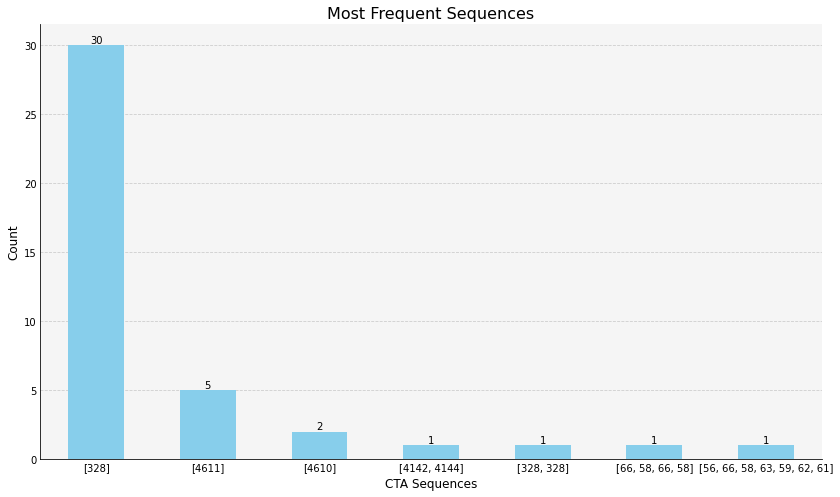

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming that 'combined_sequence' is a DataFrame with a 'page_id' column
value_counts = CTA_sequences_df['page_id'].value_counts()

# Get the top 7 most frequent pages
top_7_pages = value_counts.head(7)

# Create a larger figure to provide more space
plt.figure(figsize=(14, 8))

# Create a bar chart for the top 7 pages
ax = top_7_pages.plot.bar(color='skyblue')

plt.title('Most Frequent Sequences', fontsize=16)
plt.xlabel('CTA Sequences', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)

# Annotate the bars directly
for x, y in zip(range(len(top_7_pages)), top_7_pages):
    ax.text(x, y, round(y), ha='center', va='bottom', fontsize=10)

# Customize the grid and background
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
ax.set_axisbelow(True)

# Add a subtle background color to the plot
ax.set_facecolor('#f5f5f5')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize the tick labels and grid lines
ax.tick_params(axis='both', which='both', length=0)
ax.tick_params(axis='x', rotation=0)

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linewidth=0.5)

plt.show()

In [88]:
# Assuming you already have the 'top_7_pages' series
top_2_values = top_7_pages.index[:2]  # Get the top 2 values

# Create a boolean mask to filter rows with the top 2 values in 'page_id'
mask = CTA_sequences_df['page_id'].apply(lambda x: any(page_id in x for page_id in top_2_values))

# Use the mask to filter the DataFrame
filtered_df = CTA_sequences_df[mask]

# Display the filtered DataFrame
filtered_df.head(5)

,page_id,label
client,,
151.239.187.171,[328],1
176.65.161.111,"[328, 4611]",1
178.238.202.167,[328],1
178.252.184.54,[328],1
185.120.137.243,[4611],1


**=====================================**

## Levenshtein Distance ##

In [89]:
import Levenshtein  # noqa: E402
import numpy as np

# Initialize a matrix to store distances
num_NCTA_seqs = 20  #len(sequence_all) 
num_CTA_seqs = len(top_7_pages)  # Use the number of top CTA sequences

# Convert the top_7_pages values to a list of strings
sequence_CTA = [str(page_id) for page_id in top_7_pages.index]

lev_distances = np.zeros((num_NCTA_seqs, num_CTA_seqs), dtype=int)

# Replace this with your actual NCTA sequences (sequence_NCTA)
# You need to replace this placeholder with your actual NCTA sequences.
#sequence_NCTA = ['your', 'NCTA', 'sequences', 'go', 'here']

# Calculate Levenshtein distances
for i in range(num_NCTA_seqs):
    for j in range(num_CTA_seqs):
        # Convert sequences to strings and pad them to the same length
        max_len = max(len(sequence_all[i]), len(sequence_CTA[j]))
        sequence_NCTA_str = ''.join(map(str, sequence_all[i])).ljust(max_len, '0')
        sequence_CTA_str = sequence_CTA[j].ljust(max_len, '0')

        # Calculate Levenshtein distance
        lev_distances[i, j] = Levenshtein.distance(sequence_NCTA_str, sequence_CTA_str)

# Print the Levenshtein distances
for i in range(num_NCTA_seqs):
    for j in range(num_CTA_seqs):
        print(f"Distance between sequence_NCTA {i+1} and sequence_CTA {j+1}: {lev_distances[i, j]}")

Distance between sequence_NCTA 1 and sequence_CTA 1: 7
Distance between sequence_NCTA 1 and sequence_CTA 2: 8
Distance between sequence_NCTA 1 and sequence_CTA 3: 7
Distance between sequence_NCTA 1 and sequence_CTA 4: 11
Distance between sequence_NCTA 1 and sequence_CTA 5: 10
Distance between sequence_NCTA 1 and sequence_CTA 6: 12
Distance between sequence_NCTA 1 and sequence_CTA 7: 22
Distance between sequence_NCTA 2 and sequence_CTA 1: 30
Distance between sequence_NCTA 2 and sequence_CTA 2: 29
Distance between sequence_NCTA 2 and sequence_CTA 3: 29
Distance between sequence_NCTA 2 and sequence_CTA 4: 26
Distance between sequence_NCTA 2 and sequence_CTA 5: 28
Distance between sequence_NCTA 2 and sequence_CTA 6: 24
Distance between sequence_NCTA 2 and sequence_CTA 7: 24
Distance between sequence_NCTA 3 and sequence_CTA 1: 27
Distance between sequence_NCTA 3 and sequence_CTA 2: 25
Distance between sequence_NCTA 3 and sequence_CTA 3: 25
Distance between sequence_NCTA 3 and sequence_CTA 4

In [90]:
sequence_CTA

['[328]',
 '[4611]',
 '[4610]',
 '[4142 4144]',
 '[328 328]',
 '[66 58 66 58]',
 '[56 66 58 63 59 62 61]']

In [91]:
# Initialize a list to store recommendations
recommendations = []

# Find the index of the sequence in sequence_CTA with the minimum Levenshtein distance for each complete_sequence_data sequence
for i in range(num_NCTA_seqs):
    min_distance_idx = np.argmin(lev_distances[i])
    recommendation = sequence_CTA[min_distance_idx]  # Use sequence_CTA, not sequence_CTA_str
    recommendations.append(recommendation)

# Print the recommendations
for i, recommendation in enumerate(recommendations):
    print(f"For sequence_NCTA {i+1}, recommend the following sequence from sequence_CTA: {recommendation}")

For sequence_NCTA 1, recommend the following sequence from sequence_CTA: [328]
For sequence_NCTA 2, recommend the following sequence from sequence_CTA: [66 58 66 58]
For sequence_NCTA 3, recommend the following sequence from sequence_CTA: [4611]
For sequence_NCTA 4, recommend the following sequence from sequence_CTA: [66 58 66 58]
For sequence_NCTA 5, recommend the following sequence from sequence_CTA: [328]
For sequence_NCTA 6, recommend the following sequence from sequence_CTA: [56 66 58 63 59 62 61]
For sequence_NCTA 7, recommend the following sequence from sequence_CTA: [328]
For sequence_NCTA 8, recommend the following sequence from sequence_CTA: [4142 4144]
For sequence_NCTA 9, recommend the following sequence from sequence_CTA: [4142 4144]
For sequence_NCTA 10, recommend the following sequence from sequence_CTA: [56 66 58 63 59 62 61]
For sequence_NCTA 11, recommend the following sequence from sequence_CTA: [4142 4144]
For sequence_NCTA 12, recommend the following sequence from 